In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/Users/rogermatos/Documents/Deep Learning/InsectClassification/dataset_utils.py'>

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)
batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
#print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

In [3]:
expanded_train_dna_features = torch.load('features/expanded_train_dna_features.pt')
expanded_train_dna_labels = torch.load('features/expanded_train_dna_labels.pt')
image_train_features = torch.load('features/image_train_features.pt')
image_train_labels= torch.load('features/image_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [4]:
expanded_val_dna_features = torch.load('features/expanded_val_dna_features.pt')
expanded_val_dna_labels = torch.load('features/expanded_val_dna_labels.pt')
image_val_features = torch.load('features/image_val_features.pt')
image_val_labels= torch.load('features/image_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [5]:
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)

In [6]:
expanded_train_dna_features.shape
image_train_features.shape
complete_train_features.shape

torch.Size([13039, 7346])

## Classification

In [7]:
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features, image_train_labels)

train_predicted_labels = clf.predict(complete_train_features)
val_predicted_labels= clf.predict(complete_val_features)

temp_val_predicted_probs = clf.predict_proba(complete_val_features)
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),1050))
for i, cls in enumerate(np.arange(1050)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

In [8]:
feature_importances = clf.feature_importances_
feature_importances

array([1.28482548e-04, 2.37539937e-04, 1.05121056e-04, ...,
       2.44763428e-05, 1.13919226e-05, 3.24053704e-05])

# Accuracies

In [9]:
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels.numpy())/len(image_train_labels)}")

print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels.numpy())/len(image_val_labels)}")

Training species accuracy:1.0
Validation species accuracy:0.4570812365204889


In [10]:
import math
n_correct_genus = 0
for i in range(len(image_val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[image_val_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(image_val_labels)}")

Validation genus accuracy: 0.799137311286844


In [11]:
described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)

# Entropy method

In [19]:
def entropy_per_symbol(v):
    if len(v)==1:
        return 0.0
    entropy = 0 
    n_zeros = 0
    for p in v:
        if p != 0:
            entropy-=p*math.log(p,2)
        else:
            n_zeros +=1
    #print(f"n_zeros:{n_zeros}")
    #FORSE VA TOLTO N_ZEROS DALLA LENGTH
    mean_symbol_entropy = entropy/math.log(len(normalized_reduced_species),2)
    return mean_symbol_entropy

In [20]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
        assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
        reduced_species = val_predicted_probs[i][species_same_genus]
        normalized_reduced_species = reduced_species/(reduced_species.sum())
        H_s = entropy_per_symbol(normalized_reduced_species)
        if image_val_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if H_s < entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == image_val_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if H_s >= entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[image_val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
            
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

Text(0, 0.5, 'True Positive Rate')

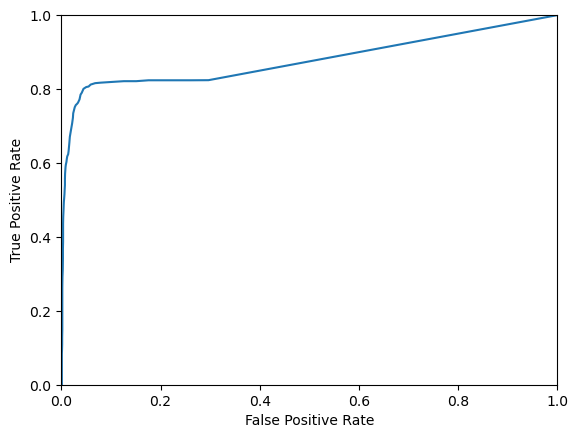

In [22]:
plt.plot(fprs,tprs)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Top-2 Method

In [12]:
tprs1 = []
fprs1 = []
correct_genus_rate1 = []
correct_species_rate1 = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples1 = 0
    n_described_samples1 = 0
    n_correct_undescribed_samples1 = 0
    n_correct_described_samples1 = 0
    n_correct_genus1 = 0 
    n_correct_species1 = 0 
    for i in range(len(image_val_labels)):
        
        label_best_specie = val_predicted_labels[i]
       
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        
        #indices =  val_predicted_probs[i].argsort()[::-1]
        
        sorted_probs = np.sort(val_predicted_probs[i])
        sorted_probs = sorted_probs[::-1]
        
        prob_diff = abs(sorted_probs[0] - sorted_probs[1])
        
        if image_val_labels[i].item() in described_species_labels:
            #tn
            n_described_samples1 +=1
            if prob_diff >= entropy_threshold:
                n_correct_described_samples1+=1
                if label_best_specie == image_val_labels[i]:
                    n_correct_species1+=1
        else:
            #tp
            n_undescribed_samples1+=1
            if prob_diff < entropy_threshold:
                n_correct_undescribed_samples1+=1
                real_genus = species2genus[image_val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus1+=1
        
            
    tprs1.append(n_correct_undescribed_samples1/n_undescribed_samples1) # TPR = recall = sensitivity
    fprs1.append(1-n_correct_described_samples1/n_described_samples1) # 1-TNR = 1 - specificity
    correct_genus_rate1.append(n_correct_genus1/n_undescribed_samples1)
    correct_species_rate1.append(n_correct_species1/n_described_samples1)

[0.0, 0.008658008658008698, 0.013296227581941822, 0.014533085961657366, 0.01546072974644408, 0.016388373531230682, 0.017006802721088454, 0.017316017316017285, 0.018243661100804, 0.01886209029066177, 0.01948051948051943, 0.01948051948051943, 0.020098948670377204, 0.020717377860234976, 0.021335807050092748, 0.02195423623995052, 0.022572665429808292, 0.022572665429808292, 0.023191094619666064, 0.023500309214594894, 0.023809523809523836, 0.023809523809523836, 0.024118738404452666, 0.02535559678416821, 0.02535559678416821, 0.025974025974025983, 0.025974025974025983, 0.026283240568954813, 0.026901669758812585, 0.026901669758812585, 0.027210884353741527, 0.0278293135435993, 0.02844774273345707, 0.029066171923314732, 0.030921459492888048, 0.03184910327767465, 0.03215831787260359, 0.032776747062461364, 0.033085961657390195, 0.033395176252319136, 0.03432282003710574, 0.03555967841682128, 0.036487322201607886, 0.03679653679653683, 0.03803339517625237, 0.038961038961038974, 0.04019789734075452, 0.

Text(0, 0.5, 'True Positive Rate')

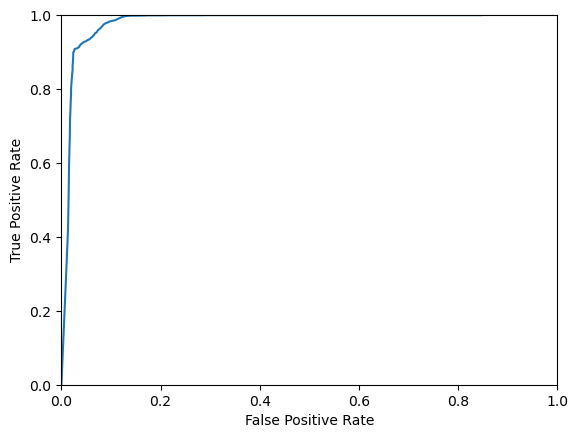

In [13]:
print(fprs1)
plt.plot(fprs1,tprs1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

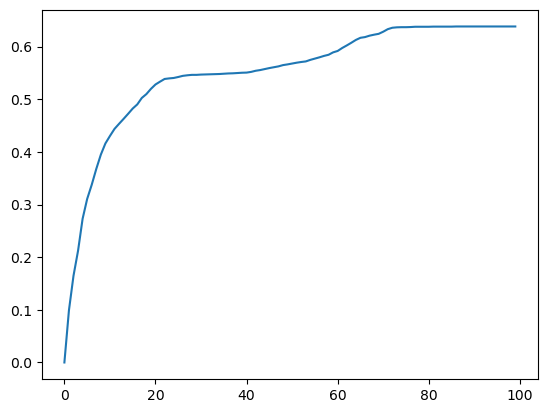

In [14]:
plt.plot(correct_genus_rate1)

Text(0, 0.5, 'Correct Genus Rate')

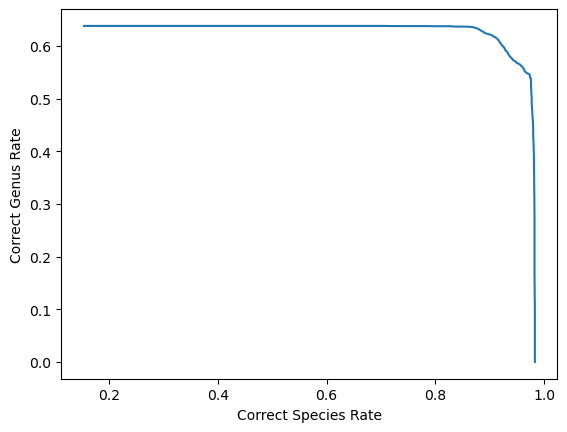

In [16]:
plt.plot(correct_species_rate1,correct_genus_rate1)
plt.xlabel("Correct Species Rate")
plt.ylabel("Correct Genus Rate")

In [35]:
for index in range(0,100,10):
    print(index)
    print(correct_genus_rate1[index])
    print(correct_species_rate1[index])
    print('\n\n')

0
0.0
0.9829931972789115



10
0.430260682612201
0.9799010513296228



20
0.528083848427842
0.9758812615955473



30
0.5468959957000806
0.9724799010513296



40
0.5506584251545283
0.9656771799628943



50
0.5678581026605751
0.9499072356215214



60
0.5917764041924214
0.9288806431663574



70
0.6283257188927708
0.8855905998763142



80
0.6377317925288901
0.7987012987012987



90
0.638269282450954
0.6069882498453927



